# Loads the processed h5 file and plots data

debugging: the pump probe signal looks weird after implementing mpi

In [49]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [50]:
# input parameters
run_groups = {
              '28 mm' : [109, 110, 111, 113],
              '35 mm' : [115,116,119,121,122,123],
              '40 mm' : [124,125,126],
              '45 mm' : [127,128,129,131],
              '50 mm' : [133,134,135,136,137],
              '55 mm' : [138,139,140,141,142,143],
              '60 mm' : [145,146,147,149],
              '65 mm' : [150,151,152,153,154,155,156],
              '70 mm' : [157,158,159,160,161,162]
              }

# analysis parameters
iq_thr = 1.1

### load and analyse data

In [61]:
def analyse_run(run_num, detector_distance = 0.12, energy = 9.5, iq_thr = iq_thr, r_min=20, r_max = 30):
    '''
    loads and analyses a single run
    '''
    
    # load data
    run = discover_run_h5(run_num)[3:-3]
    img,Iq,r,nshots,img_hits,thr,nhits,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

    # convert q_scale
    q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

    # convert intensity to photon/pix
    Iq /=energy
    i0 /=energy

    # normalise to i0
    Iq_norm = np.zeros(Iq.shape)
    i0_avg = np.average(i0)
    norm = i0/i0_avg
    for i in range(int(nshots)):
        Iq_norm[i]=Iq[i]/norm[i]

    # hits
    metric,hits = find_hits(Iq_norm,threshold=iq_thr)
    hit_rate =len(hits[hits>0])/nshots
    
    # ice
    filter_length = 1      # 1 = filter off
    ice_thr = 1.0          # delta photon/pix/i0
    q_min, q_max = 1.0,4.5 # A-1
    ice_metric, ice_hits = find_ice(Iq_norm, q, threshold=ice_thr, 
                                    filter_length=filter_length, q_min=q_min, q_max=q_max)

    hits *= np.logical_not(ice_hits)
    
    # weak hit rejection
    misses = np.logical_not(hits) & (i0[:nshots] > i0_avg - 2*i0[:nshots].std()) # remove weak x-ray shots (2 std)
    hits = hits & (i0[:nshots] > i0_avg - 2*i0[:nshots].std()) # remove weak x-ray shots (2 std)
    
    # laser rejection
    #l = laser_i0[laser_on.astype(np.bool)][:nshots]
    #laser_outliers = laser_on.astype(np.bool) & ((laser_i0 > (l.mean() + l.std())) | (laser_i0 < (l.mean() - l.std())))
    #hits *= np.logical_not(laser_outliers)
    
    # pump probe
    hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on,misses=misses)
    #hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on)
    print('hits: %d, laser on: %d' % (hits.sum(), (hits & laser_on).sum()))
    return q,hit_avg,miss_avg,diff_signal,hit_rate,hits.sum(),(hits & laser_on).sum()



In [62]:
run_means = {}

for rg in run_groups.keys():
    
    runs = run_groups[rg]

    n = len(runs)
    data = analyse_run(runs[0])
    q = data[0]
    hit = data[1]
    miss = data[2]
    diff = data[3]
    hr = data[4]
    nhits = data[5]
    nhits_laser = data[6]
    
    for i in range(1,n):
        data = analyse_run(runs[i])
        hit = np.vstack([hit,data[1]])
        miss = np.vstack([miss,data[2]])
        diff = np.vstack([diff,data[3]])
        hr = np.vstack([hr,data[4]])
        nhits = np.vstack([nhits,data[5]])
        nhits_laser = np.vstack([nhits_laser,data[6]])
    
    run_means[rg] = [ q, hit.mean(0), miss.mean(0), diff.mean(0), hr.mean(0), nhits.sum(0), nhits_laser.sum(0) ]


run0109_droplets_10um_28mm: 18000 shots
hits: 72, laser on: 33
run0110_droplets_10um_28mm: 18000 shots
hits: 47, laser on: 25
run0111_droplets_10um_28mm: 18000 shots
hits: 53, laser on: 32
run0113_droplets_10um_28mm: 18000 shots
hits: 42, laser on: 22
run0115_droplets_10um_35mm: 18000 shots
hits: 41, laser on: 20
run0116_droplets_10um_35mm: 18000 shots
hits: 31, laser on: 16
run0119_droplets_10um_35mm: 18000 shots
hits: 42, laser on: 20
run0121_droplets_10um_35mm: 18000 shots
hits: 30, laser on: 13
run0122_droplets_10um_35mm: 18000 shots
hits: 31, laser on: 13
run0123_droplets_10um_35mm: 18000 shots
hits: 42, laser on: 16
run0124_droplets_10um_35mm: 18000 shots
hits: 26, laser on: 14
run0125_droplets_10um_40mm: 18000 shots
hits: 28, laser on: 12
run0126_droplets_10um_40mm: 18000 shots
hits: 25, laser on: 12
run0127_droplets_10um_45mm: 18000 shots
hits: 5, laser on: 3
run0128_droplets_10um_45mm: 18000 shots
hits: 7, laser on: 4
run0129_droplets_10um_45mm: 18000 shots
hits: 5, laser on: 

/sf/bernina/anaconda/4.4.0/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sf/bernina/anaconda/4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


hits: 1, laser on: 0
run0135_droplets_10um_50mm: 18000 shots
hits: 11, laser on: 3
run0136_droplets_10um_50mm: 18000 shots
hits: 15, laser on: 10
run0137_droplets_10um_50mm: 18000 shots
hits: 15, laser on: 9
run0138_droplets_10um_55mm: 18000 shots
hits: 9, laser on: 4
run0139_droplets_10um_55mm: 18000 shots
hits: 9, laser on: 3
run0140_droplets_10um_55mm: 18000 shots
hits: 9, laser on: 7
run0141_droplets_10um_55mm: 18000 shots
hits: 6, laser on: 3
run0142_droplets_10um_55mm: 18000 shots
hits: 9, laser on: 5
run0143_droplets_10um_55mm: 18000 shots
hits: 13, laser on: 6
run0145_droplets_10um_60mm: 18000 shots
hits: 6, laser on: 4
run0146_droplets_10um_60mm: 18000 shots
hits: 10, laser on: 6
run0147_droplets_10um_60mm: 18000 shots
hits: 16, laser on: 6
run0149_droplets_10um_60mm: 18000 shots
hits: 14, laser on: 6
run0150_droplets_10um_65mm: 18000 shots
hits: 4, laser on: 1
run0151_droplets_10um_65mm: 18000 shots
hits: 5, laser on: 5
run0152_droplets_10um_65mm: 18000 shots
hits: 12, laser 

### plot

<IPython.core.display.Javascript object>


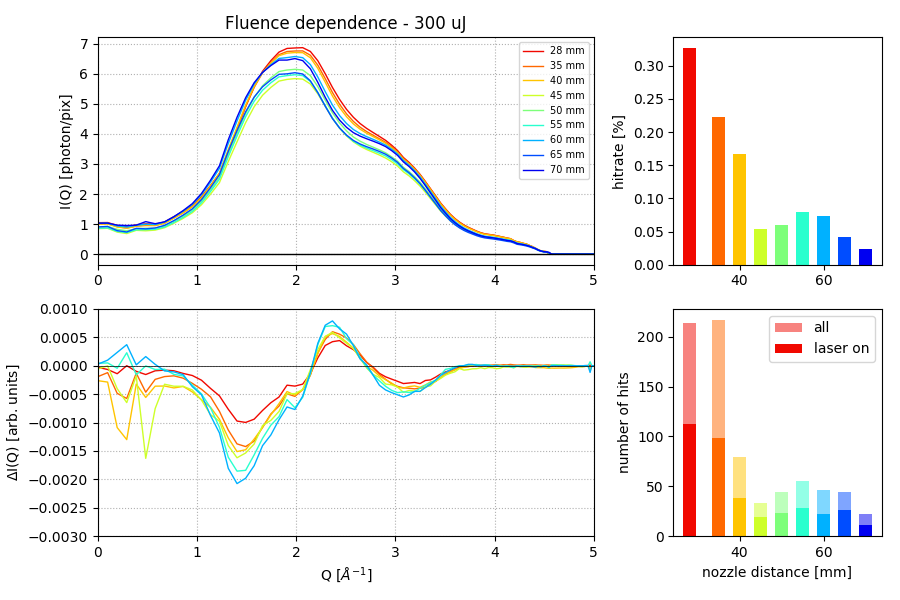

In [63]:
col = plt.cm.jet(np.linspace(0.1, 0.9, len(run_means.keys())))[::-1] 

plt.figure(figsize=[9,6])

plt.subplot2grid((2,3),(0,0),colspan=2)
plt.title('Fluence dependence - 300 uJ')
for n,rg in enumerate(run_means.keys()):
    hit  = run_means[rg][1]
    miss = run_means[rg][2]
    plt.plot(q, hit - miss, label=rg, lw=1, color=col[n])
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right',fontsize=7)
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')

plt.subplot2grid((2,3),(1,0),colspan=2)
for n,rg in enumerate(run_means.keys()):
    plt.plot(q, run_means[rg][3], label=rg, lw=1, color=col[n])
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-3e-3,1e-3])
plt.xlabel('Q [$\AA^{-1}$]')
#plt.legend(loc='upper right',fontsize=6)
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=0.5)

plt.subplot2grid((2,3),(0,2))
for n,rg in enumerate(run_means.keys()):
    plt.bar(int(rg[:2]), run_means[rg][4]*100, width=3, color=col[n])
plt.ylabel('hitrate [%]')
#plt.xlabel('nozzle distance [mm]')

plt.subplot2grid((2,3),(1,2))
for n,rg in enumerate(run_means.keys()):
    plt.bar(int(rg[:2]), run_means[rg][5], width=3, alpha=0.5, color=col[n])
    plt.bar(int(rg[:2]), run_means[rg][6], width=3, color=col[n])
plt.legend(['all', 'laser on'])
plt.ylabel('number of hits')
plt.xlabel('nozzle distance [mm]')

plt.tight_layout()
plt.savefig('master_plot_diff_signal_cleaned.png')
plt.show()

In [64]:
plt.figure()
plt.plot(run_means['70 mm'][0], run_means['70 mm'][]

[array([ 0.        ,  0.09651594,  0.19294468,  0.28919946,  0.38519442,
         0.48084505,  0.57606857,  0.67078435,  0.76491428,  0.8583831 ,
         0.95111873,  1.0430525 ,  1.13411943,  1.2242584 ,  1.3134123 ,
         1.40152818,  1.48855729,  1.57445513,  1.6591815 ,  1.74270042,
         1.82498009,  1.90599285,  1.98571502,  2.06412678,  2.14121207,
         2.21695838,  2.2913566 ,  2.36440084,  2.43608824,  2.50641879,
         2.57539508,  2.64302221,  2.70930749,  2.77426032,  2.83789198,
         2.90021546,  2.96124529,  3.02099735,  3.07948875,  3.13673768,
         3.19276322,  3.24758527,  3.30122439,  3.35370171,  3.40503879,
         3.45525756,  3.50438022,  3.55242912,  3.59942675,  3.64539563,
         3.69035823,  3.73433698,  3.77735416,  3.81943188,  3.86059203,
         3.90085628,  3.940246  ,  3.97878225,  4.0164858 ,  4.05337704,
         4.08947601,  4.1248024 ,  4.15937547,  4.19321413,  4.22633687,
         4.25876178,  4.29050654,  4.32158843,  4.3